In [1]:
import numpy as np
import xarray as xr
import xrft

from matplotlib import pyplot as plt
%matplotlib inline

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# time

time_length = 600

ds = xr.Dataset(coords={'time': ('time', np.arange(time_length)*3600.)})
# wave-like signals
ds = ds.assign(u_cos = np.cos(2.*np.pi*2/86400.*ds.time).chunk({'time': time_length}) )
# wave-like signals + random noise
ds = ds.assign(u_cos_noise = ds.u_cos + np.random.randn(ds.time.size)/5)
# wave-like signals + linear(positive) trend
ds = ds.assign(u_cos_trend = ds.u_cos + np.arange(time_length)/time_length)
# wave-like signals + random noise + linear(positive) trend
ds = ds.assign(u_cos_noise_trend = ds.u_cos_noise + np.arange(time_length)/time_length)

print(ds)

<xarray.Dataset>
Dimensions:            (time: 600)
Coordinates:
  * time               (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 ...
Data variables:
    u_cos              (time) float64 dask.array<shape=(600,), chunksize=(600,)>
    u_cos_noise        (time) float64 dask.array<shape=(600,), chunksize=(600,)>
    u_cos_trend        (time) float64 dask.array<shape=(600,), chunksize=(600,)>
    u_cos_noise_trend  (time) float64 dask.array<shape=(600,), chunksize=(600,)>


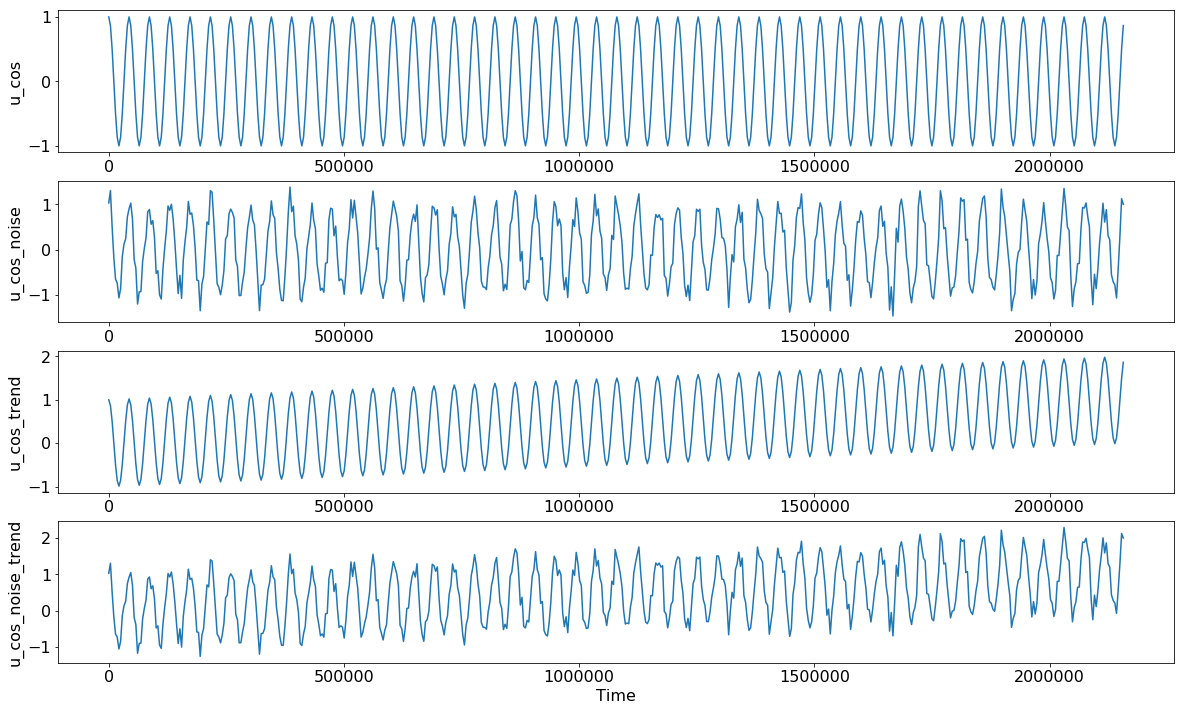

In [3]:
fig, ax = plt.subplots(figsize=(20,12))

ax = plt.subplot(4,1,1)
ds.u_cos.plot()
ax.set_xlabel('',fontsize=16)
ax.set_ylabel('u_cos',fontsize=16)
ax.tick_params(labelsize=16)

ax = plt.subplot(4,1,2)
ds.u_cos_noise.plot()
ax.set_xlabel('',fontsize=16)
ax.set_ylabel('u_cos_noise',fontsize=16)
ax.tick_params(labelsize=16)

ax = plt.subplot(4,1,3)
ds.u_cos_trend.plot()
ax.set_xlabel('',fontsize=16)
ax.set_ylabel('u_cos_trend',fontsize=16)
ax.tick_params(labelsize=16)

ax = plt.subplot(4,1,4)
ds.u_cos_noise_trend.plot()
ax.set_xlabel('Time',fontsize=16)
ax.set_ylabel('u_cos_noise_trend',fontsize=16)
ax.tick_params(labelsize=16)

# 2. Normal FFT 

In [7]:
# wave-like signals + random noise + linear(positive) trend

u_normal = ds['u_cos_noise_trend']
#u_normal = ds['u_cos_trend']

# raw
u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend=False, window=False,chunks_to_segments=False)
E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/time_length*3600
#E_u_normal = E_u_normal.mean(dim=['time_segment']) 
E_raw = np.real(E_u_normal).rename('E_raw')

# windowing
u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend=False, window=True,chunks_to_segments=False)
E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/time_length*3600
#E_u_normal = E_u_normal.mean(dim=['time_segment']) 
E_raw_window = np.real(E_u_normal).rename('E_raw_window')

# linear detrending
u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend='linear', window=False,chunks_to_segments=False)
E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/time_length*3600
#E_u_normal = E_u_normal.mean(dim=['time_segment']) 
E_raw_linear = np.real(E_u_normal).rename('E_raw_linear')

# windowing + linear detrending
u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend='linear', window=True,chunks_to_segments=False)
E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/time_length*3600
#E_u_normal = E_u_normal.mean(dim=['time_segment']) 
E_raw_window_linear = np.real(E_u_normal).rename('E_raw_window_linear')

In [8]:
# diff_f
df=E_raw_linear.freq_time[1]-E_raw_linear.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(4.62963e-07)
Coordinates:
    freq_time_spacing  float64 4.63e-07


In [9]:
E_raw = E_raw.assign_coords(freq_time=E_raw.freq_time * 86400.) 
E_raw_window = E_raw_window.assign_coords(freq_time=E_raw_window.freq_time * 86400.) 
E_raw_linear = E_raw_linear.assign_coords(freq_time=E_raw_linear.freq_time * 86400.) 
E_raw_window_linear = E_raw_window_linear.assign_coords(freq_time=E_raw_window_linear.freq_time * 86400.) 

Text(0.5,1,'')

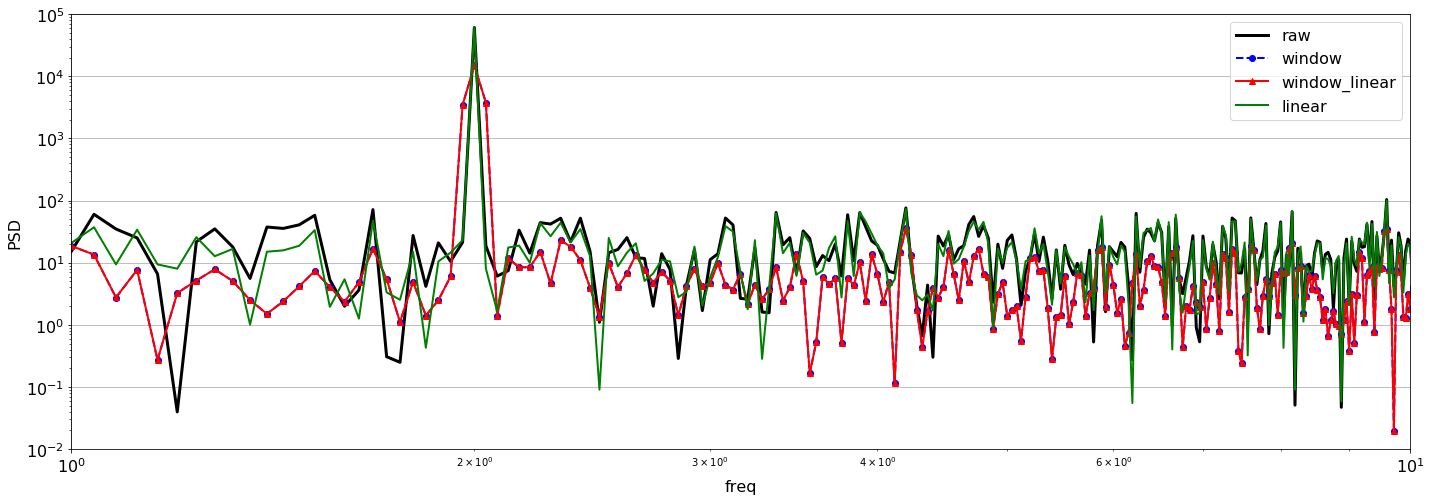

In [10]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['raw', 'window','window_linear','linear']

(E_raw/8.64).where(E_raw.freq_time>0).plot(ax=ax,color='black', label=labels[0], linewidth=3)
(E_raw_window/8.64).where(E_raw_window.freq_time>0).plot(ax=ax,color='blue', label=labels[1], linewidth=2, linestyle="--", marker='o')
(E_raw_window_linear/8.64).where(E_raw_window_linear.freq_time>0).plot(ax=ax,color='red', label=labels[2], linewidth=2, marker='^')
(E_raw_linear/8.64).where(E_raw_linear.freq_time>0).plot(ax=ax,color='green', label=labels[3], linewidth=2)

ax.legend(); ax.grid()
ax.set_xscale('log'); 
ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_ylim([1e-2,1e5])
ax.set_xlim([2*1e-2,2*1e1])
ax.set_xlim([1*1e0,1e1])

ax.legend(prop={'size': 16}); 
ax.tick_params(labelsize=16)
ax.set_xlabel('freq',fontsize=16)
ax.set_ylabel('PSD',fontsize=16)
ax.set_title('',fontsize=16)

Text(0.5,1,'')

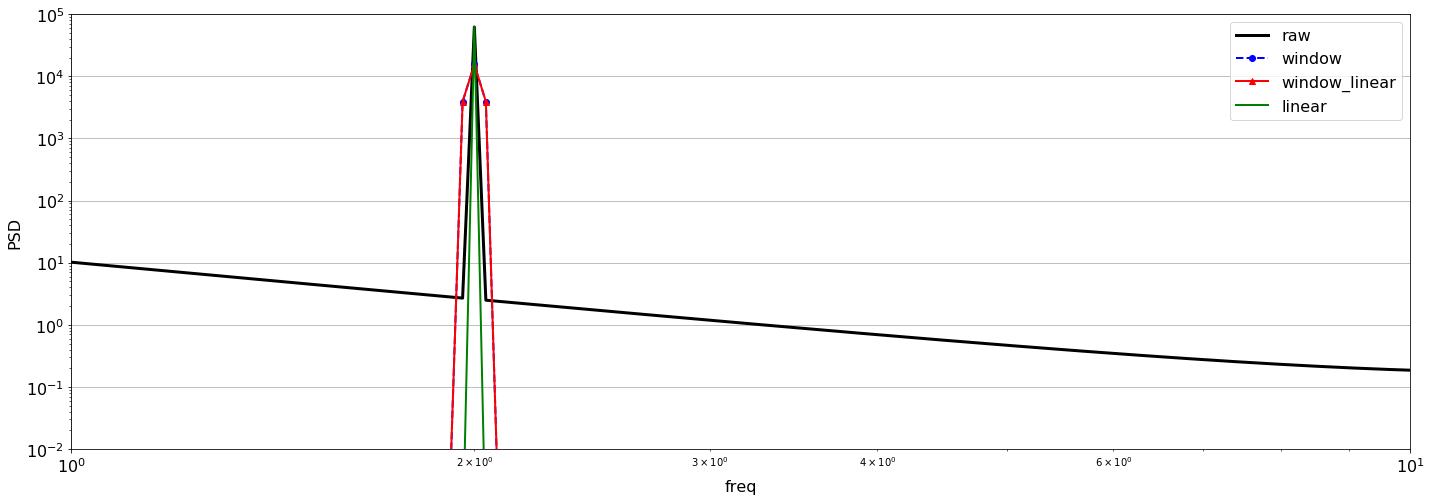

In [20]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['raw', 'window','window_linear','linear']

(E_raw/8.64).where(E_raw.freq_time>0).plot(ax=ax,color='black', label=labels[0], linewidth=3)
(E_raw_window/8.64).where(E_raw_window.freq_time>0).plot(ax=ax,color='blue', label=labels[1], linewidth=2, linestyle="--", marker='o')
(E_raw_window_linear/8.64).where(E_raw_window_linear.freq_time>0).plot(ax=ax,color='red', label=labels[2], linewidth=2, marker='^')
(E_raw_linear/8.64).where(E_raw_linear.freq_time>0).plot(ax=ax,color='green', label=labels[3], linewidth=2)

ax.legend(); ax.grid()
ax.set_xscale('log'); 
ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_ylim([1e-2,1e5])
ax.set_xlim([2*1e-2,2*1e1])
ax.set_xlim([1*1e0,1e1])

ax.legend(prop={'size': 16}); 
ax.tick_params(labelsize=16)
ax.set_xlabel('freq',fontsize=16)
ax.set_ylabel('PSD',fontsize=16)
ax.set_title('',fontsize=16)

In [21]:
(ds.u_cos**2).mean(dim='time').compute()

<xarray.DataArray 'u_cos' ()>
array(0.5)

In [22]:
E = E_raw_linear 
(E.where((abs(E.freq_time)>1.90) & (abs(E.freq_time)<2.1) , other=0.)*df).sum(dim='freq_time').compute() #####

<xarray.DataArray ()>
array(0.499983)
Coordinates:
    freq_time_spacing  float64 4.63e-07

In [23]:
E = E_raw
(E.where((abs(E.freq_time)>1.90) & (abs(E.freq_time)<2.1) , other=0.)*df).sum(dim='freq_time').compute() #####

<xarray.DataArray ()>
array(0.498437)
Coordinates:
    freq_time_spacing  float64 4.63e-07

In [26]:
E = E_raw_window
(E.where((abs(E.freq_time)>1.90) & (abs(E.freq_time)<2.1) , other=0.)*df).sum(dim='freq_time').compute() #####

<xarray.DataArray ()>
array(0.187187)
Coordinates:
    freq_time_spacing  float64 4.63e-07

In [25]:
E = E_raw_window_linear
(E.where((abs(E.freq_time)>1.90) & (abs(E.freq_time)<2.1) , other=0.)*df).sum(dim='freq_time').compute() #####

<xarray.DataArray ()>
array(0.187187)
Coordinates:
    freq_time_spacing  float64 4.63e-07

In [13]:
0.187187*(8/3)

0.4991653333333333

__________

In [63]:
print(ds)

<xarray.Dataset>
Dimensions:            (time: 3000)
Coordinates:
  * time               (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 ...
Data variables:
    u_cos              (time) float64 1.0 0.866 0.5 6.123e-17 -0.5 -0.866 ...
    u_cos_noise        (time) float64 1.054 1.813 -0.1002 -1.404 -2.085 ...
    u_cos_trend        (time) float64 1.0 0.867 0.502 0.003 -0.496 -0.861 ...
    u_cos_noise_trend  (time) float64 1.054 1.814 -0.09816 -1.401 -2.081 ...


In [63]:
u_normal = ds['u_cos_noise']

u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend=False, window=True)

E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/3000*3600

E_u_cos = np.real(E_u_normal).rename('E_u_cos')
E_u_cos

<xarray.DataArray 'E_u_cos' (freq_time: 3000)>
dask.array<shape=(3000,), dtype=float64, chunksize=(3000,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08

In [64]:
u_normal = ds['u_cos_noise_trend']

u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend='linear', window=True)

E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/3000*3600

E_u_cos_trend = np.real(E_u_normal).rename('E_u_cos_trend')
E_u_cos_trend

<xarray.DataArray 'E_u_cos_trend' (freq_time: 3000)>
dask.array<shape=(3000,), dtype=float64, chunksize=(3000,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08

In [65]:
# diff_f
df=E_u_cos.freq_time[1]-E_u_cos.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(9.259259e-08)
Coordinates:
    freq_time_spacing  float64 9.259e-08


In [66]:
E_u_cos = E_u_cos.assign_coords(freq_time=E_u_cos.freq_time * 86400.) 
E_u_cos_trend = E_u_cos_trend.assign_coords(freq_time=E_u_cos_trend.freq_time * 86400.) 

(0.008, 10.0)

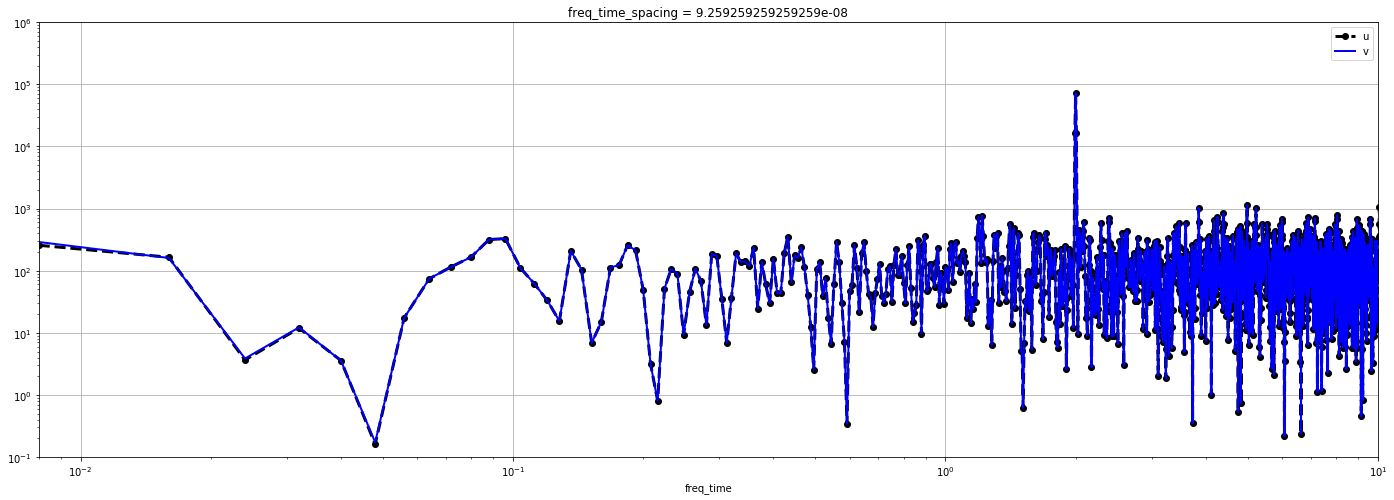

In [67]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['u', 'v']

(E_u_cos/8.64).where(E_u_cos.freq_time>0).plot(ax=ax,color='black', label=labels[0], linewidth=3, linestyle="--", marker='o')
(E_u_cos_trend/8.64).where(E_u_cos_trend.freq_time>0).plot(ax=ax,color='blue', label=labels[1], linewidth=2)

ax.legend(); ax.grid()
ax.set_xscale('log'); 
ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_ylim([1e-1,1e6])
ax.set_xlim([8*1e-3,1*1e1])

(0.008, 10.0)

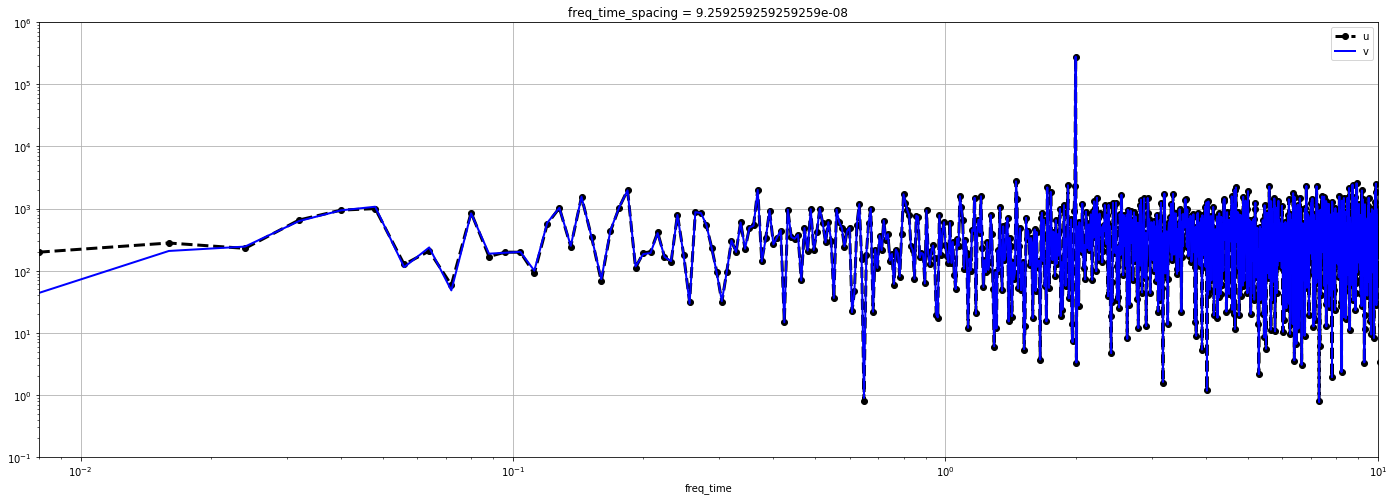

In [81]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['u', 'v']

(E_u_cos/8.64).where(E_u_cos.freq_time>0).plot(ax=ax,color='black', label=labels[0], linewidth=3, linestyle="--", marker='o')
(E_u_cos_trend/8.64).where(E_u_cos_trend.freq_time>0).plot(ax=ax,color='blue', label=labels[1], linewidth=2)

ax.legend(); ax.grid()
ax.set_xscale('log'); 
ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_ylim([1e-1,1e6])
ax.set_xlim([8*1e-3,1*1e1])

In [68]:
(E_raw.where((abs(E_raw.freq_time)>1.99) & (abs(E_raw.freq_time)<2.01) , other=0.)*df).sum(dim='freq_time').compute() #####

<xarray.DataArray ()>
array(0.499022)
Coordinates:
    freq_time_spacing  float64 9.259e-08

In [162]:
(E_v_normal_w.where((abs(E_v_normal_w.freq_time)>1.99) & (abs(E_v_normal_w.freq_time)<2.10) , other=0.)*df).sum(dim='freq_time').compute() #####

<xarray.DataArray ()>
array(0.524074)
Coordinates:
    freq_time_spacing  float64 9.259e-08

In [163]:
(E_u_normal_w*df).sum(dim='freq_time').compute() ############

<xarray.DataArray ()>
array(1.546415)
Coordinates:
    freq_time_spacing  float64 9.259e-08

In [164]:
(E_v_normal_w*df).sum(dim='freq_time').compute() ############

<xarray.DataArray ()>
array(4.64502)
Coordinates:
    freq_time_spacing  float64 9.259e-08